# Pocket-level evaluation for P2Rank
Replicate the approach from `./pocket-level-evaluation.ipynb` on the CryptoBench test set, however, on the results from P2Rank.

In [1]:
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import cryptoshow_utils

P2RANK_PREDICTIONS_PATH = '/home/vit/Projects/cryptobench/data/H-prediction-evaluation/ahoj-v2/p2rank/p2rank-predictions/predict_single-pair-test_apo'

def read_predicted_pockets_p2rank(protein_ids) -> dict[str, list[set[int]]]:
    '''Reads predicted pockets from P2Rank output files.
    Args:
        protein_ids: List of protein IDs in the format PDB-ID_CHAIN-ID (e.g. 1abc_A)
    Returns:
        predicted_pockets: A dictionary mapping protein IDs to a list of predicted pockets,
        where each pocket is represented as a set of residue indices (integers).
        sequences: A dictionary mapping protein IDs to their corresponding sequences.
    '''
    predicted_pockets = {}
    sequences = {}

    for protein_id in protein_ids:
        pdb_id, chain_id = protein_id.split('_')
        filename = f'{P2RANK_PREDICTIONS_PATH}/{pdb_id.lower()}.cif_predictions.csv'
        with open(filename, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            next(reader)  # skip header
            data = list(reader)
            row_count = len(data)

            pockets = []

            if row_count == 0:
                predicted_pockets[protein_id] = pockets
                _, sequence = cryptoshow_utils.map_residues_to_mmcif(pdb_id, chain_id, [])
                sequences[protein_id] = sequence
                continue

            for row in data:
                residue_indices = row[9].strip().split(' ')

                # check that they have correct chain id and add collect them
                pocket_residues = set()
                for res_idx in residue_indices:
                    this_chain_id, res_num = res_idx.split('_')
                    if this_chain_id != chain_id:
                        continue
                    pocket_residues.add(res_num)
                
                pocket_residues, sequence = cryptoshow_utils.map_residues_to_mmcif(pdb_id, chain_id, pocket_residues)
                pockets.append(pocket_residues)
                sequences[protein_id] = sequence
            predicted_pockets[protein_id] = pockets

    return predicted_pockets, sequences

In [ ]:
# load CB test set and P2Rank predictions
from eval_utils import read_test_binding_residues
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['CRYPTIC'])
predicted_pockets, sequences = read_predicted_pockets_p2rank(cryptic_binding_residues.keys())

# check that sequences match (the ground-truth sequences taken from the src/A-cluster-ligysis-data/main.ipynb and the sequences extracted from the mmCIF files when reading the P2Rank predictions)
for key in cryptic_binding_residues.keys():
    assert ground_truth_sequences[key] == sequences[key], f"Sequences do not match for {key}!"

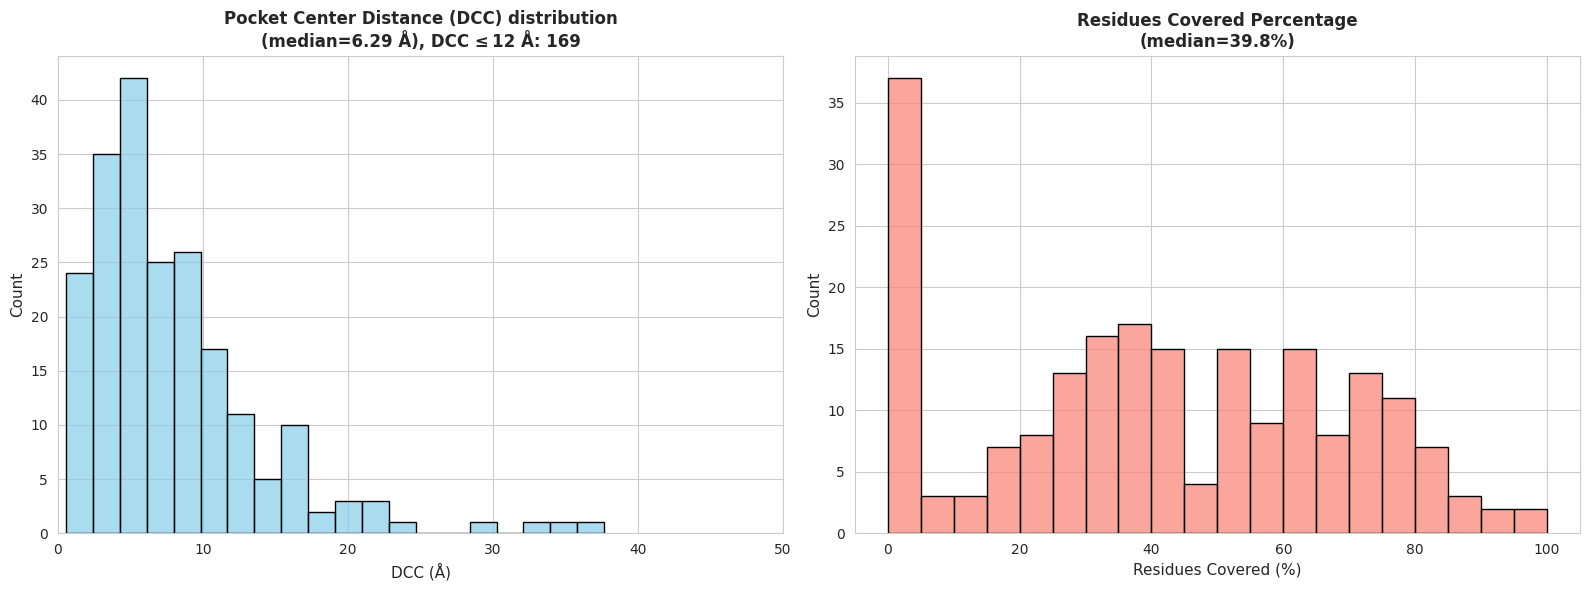

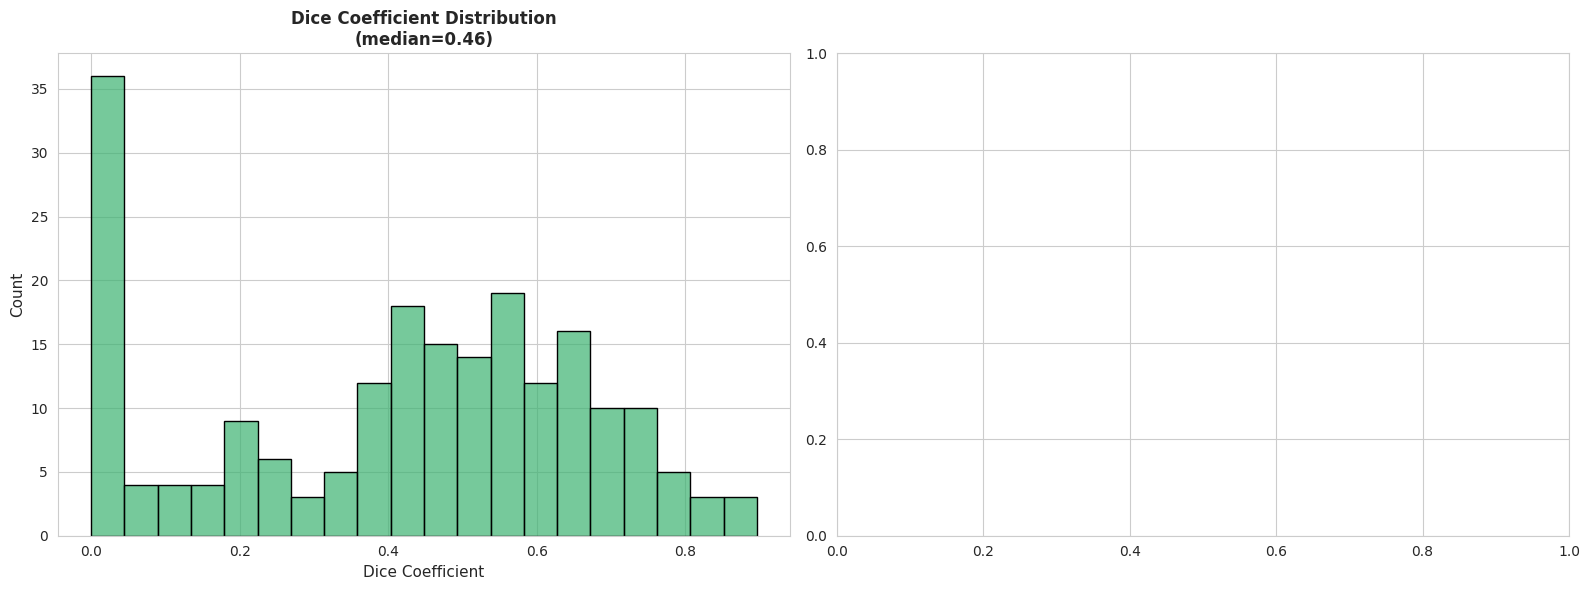

In [ ]:
COORDINATES_DIR = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

def create_plots():
    dcc_values = []
    dice_coefficients = []
    residues_covered_percent = []

    for structure, cryptic_pocket_list in cryptic_binding_residues.items():
        if structure not in predicted_pockets:
            continue

        unrefined = predicted_pockets[structure]
        coordinates_path = f"{COORDINATES_DIR}/{structure.replace('_', '')}.npy"
        ca_coords = np.load(coordinates_path)

        for cryptic_pocket in cryptic_pocket_list:
            total_residues_covered = 0
            cryptic_pocket_residues = set([residue.split("_")[1] for residue in cryptic_pocket])

            expected_indices = [int(i) for i in cryptic_pocket_residues]

            best_dist = float('inf')
            best_dice = 0
            best_covered = 0

            for potential_pocket in unrefined:
                # potential_pocket is a tuple: (residues, indices)
                indices_array = potential_pocket
                potential_pocket_str = set(str(r[1:]) for r in indices_array)
                residues_covered = len(potential_pocket_str & cryptic_pocket_residues)
                total_residues_covered += residues_covered

                actual_indices = [int(i) for i in potential_pocket_str]

                if len(expected_indices) == 0 or len(actual_indices) == 0:
                    continue

                dist = cryptoshow_utils.compute_center_distance(np.array(ca_coords), expected_indices, actual_indices)
                dice_coefficient = 2 * residues_covered / (len(cryptic_pocket_residues) + len(potential_pocket_str)) if (len(cryptic_pocket_residues) + len(potential_pocket_str)) > 0 else 0

                if dist < best_dist:
                    best_dist = dist  
                if residues_covered > best_covered:
                    best_covered = residues_covered
                if dice_coefficient > best_dice:
                    best_dice = dice_coefficient

            percent_covered = best_covered / len(cryptic_pocket_residues) * 100 if cryptic_pocket_residues else 0
            # avoid the corner cases
            if np.isfinite(best_dist):
                dcc_values.append(best_dist)

                dice_coefficients.append(best_dice)
                residues_covered_percent.append(percent_covered)

    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(dcc_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'Pocket Center Distance (DCC) distribution\n(median={np.median(dcc_values):.2f} Å), DCC ≤ 12 Å: {np.sum(np.array(dcc_values) < 12)}', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('DCC (Å)', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)
    axs[0].set_xlim(0, 50)

    sns.histplot(residues_covered_percent, bins=20, color='salmon', edgecolor='black', alpha=0.7, ax=axs[1])
    axs[1].set_title(f'Residues Covered Percentage\n(median={np.median(residues_covered_percent):.1f}%)', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Residues Covered (%)', fontsize=11)
    axs[1].set_ylabel('Count', fontsize=11)

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(dice_coefficients, bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'Dice Coefficient Distribution\n(median={np.median(dice_coefficients):.2f})', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('Dice Coefficient', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)

    # sns.histplot(prediction_scores_list, bins=20, color='gold', edgecolor='black', alpha=0.7, ax=axs[1])
    # axs[1].axvline(0.7, color='red', linestyle='--', linewidth=2, label='Threshold = 0.7')
    # axs[1].set_title(f'Prediction Scores of Test Set CBSs\n(avg={np.mean(prediction_scores_list):.2f})', fontsize=12, fontweight='bold')
    # axs[1].set_xlabel('Prediction Score', fontsize=11)
    # axs[1].set_ylabel('Count', fontsize=11)
    # axs[1].legend(fontsize=10)

    plt.tight_layout()
    plt.show()

create_plots()

In [ ]:
cryptic_binding_residues, ground_truth_sequences = read_test_binding_residues(data_path='/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt', pocket_types=['CRYPTIC', 'NON-CRYPTIC'])
create_plots()